In [1]:
from ete3 import Tree
import networkx as nx 
import pandas as pd 
import numpy as np
from functools import reduce
from tqdm import tqdm_notebook
import pickle as pic 

from collections import OrderedDict, defaultdict

import scipy.stats as scs
import cassiopeia.TreeSolver.compute_meta_purity as cmp
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
import os 

from scipy.linalg import eig 
import matplotlib

import utilities.compute_transition_probs as ctp
import utilities.fitch_parsimony as fp
import utilities.sankoff_parsimony as sankoff_parsimony

from contextlib import suppress

from cassiopeia.TreeSolver.Node import Node

In [2]:
def reconcile_fitch(T):
    
    source = [n for n in T if T.in_degree(n) == 0][0]
    for e in nx.dfs_edges(T):
        
        p, c = e[0], e[1]
        ns = np.intersect1d(T.nodes[p]['label'], T.nodes[c]['label']).tolist()
        
        if len(ns) > 0:
            T.nodes[c]['label'] = ns 
        else:
            T.nodes[c]['label'] = list(T.nodes[c]['label'])
    return T

def count_opt_solutions(T, possible_assignments, node_to_i, label_to_j):
    
    def fill_DP(v, s):

        if t.out_degree(v) == 0:
            return 1
        
        children = list(T.successors(v))
        A = np.zeros((len(children)))
        
        for i, u in zip(range(len(children)), children):
            if s not in T.nodes[u]['label']:
                A[i] = 0
                for sp in T.nodes[u]['label']:
                    print(node_to_i[u], t.nodes[u]['label'])
                    if L[node_to_i[u], label_to_j[sp]] == 0:
                        L[node_to_i[u], label_to_j[sp]] = fill_DP(u, sp)
                    A[i] += L[node_to_i[u], label_to_j[sp]]
            else:
                if L[node_to_i[u], label_to_j[s]] == 0:
                    L[node_to_i[u], label_to_j[s]] = fill_DP(u, s)
                A[i] = L[node_to_i[u], label_to_j[s]]
                
        return np.prod([A[u] for u in range(len(A))])
    
    L = np.full((len(T.nodes), len(possible_assignments)), 0)
    
    root = [n for n in T if T.in_degree(n) == 0][0]
    
    for s in T.nodes[root]['label']:
        L[node_to_i[root], label_to_j[s]] = fill_DP(root, s)
        
    return L

def count_num_transitions(T, L, possible_labels, node_to_i, label_to_j):
    
    def fill_transition_DP(v, s, s1, s2):
        
        if t.out_degree(v) == 0:
            return 0
        
        children = list(T.successors(v))
        A = np.zeros((len(children)))
        LS = [[]] * len(children)
        
        for i, u in zip(range(len(children)), children):
            LS_u = None
            if s in T.nodes[u]['label']:
                LS[i] = [s]
            else:
                LS[i] = T.nodes[u]['label']
            
            A[i] = 0
            for sp in LS[i]:
                if C[node_to_i[u], label_to_j[sp], label_to_j[s1], label_to_j[s2]] == 0:
                    C[node_to_i[u], label_to_j[sp], label_to_j[s1], label_to_j[s2]] = fill_transition_DP(u, sp, s1, s2)
                A[i] += C[node_to_i[u], label_to_j[sp], label_to_j[s1], label_to_j[s2]]
            
            if (s1 == s and s2 in LS[i]):
                A[i] += L[node_to_i[u], label_to_j[s2]]
        
        parts = []
        for i, u in zip(range(len(children)), children):
            prod = 1
            
            for k, up in zip(range(len(children)), children):
                if up == u:
                    continue
                for sp in LS[k]:
                    prod *= L[node_to_i[up], label_to_j[sp]]
                
            part = A[i] * prod
            parts.append(part)
        return np.sum(parts)
    
    C = np.zeros((len(T.nodes), L.shape[1], L.shape[1], L.shape[1]))
    root = [n for n in T if T.in_degree(n) == 0][0]
    #C[node_to_i[root], label_to_j['H'], label_to_j['H'], label_to_j['L']] = fill_transition_DP(root, 'H', "H", "L")
    for s in T.nodes[root]['label']:
        for s1 in possible_labels:
            for s2 in possible_labels:
                if s1 == s2:
                    continue
                C[node_to_i[root], label_to_j[s], label_to_j[s1], label_to_j[s2]] = fill_transition_DP(root, s, s1, s2)
    return C

def compute_transitions(t, meta):

    root = [n for n in t if t.in_degree(n) == 0][0]
    t = ctp.assign_labels(t, meta)
    possible_labels = meta.unique()

    t = cmp.set_depth(t, root)
    t = fp.fitch_bottom_up(t, root)

    bfs_postorder = [root]
    for e0, e1 in nx.bfs_edges(t, root):
        bfs_postorder.append(e1)

    node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
    label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

    t = reconcile_fitch(t)

    L = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)

    C = count_num_transitions(t, L, possible_labels, node_to_i, label_to_j)

    count_mat = pd.DataFrame(np.zeros((L.shape[1], L.shape[1])))
    count_mat.columns = possible_labels
    count_mat.index = possible_labels 

    # count_mat: transitions are rows -> columns
    for s1 in possible_labels:
        for s2 in possible_labels:
            count_mat.loc[s1, s2] = np.sum(C[node_to_i[root], :, label_to_j[s1], label_to_j[s2]])

    return count_mat


In [3]:
t = nx.balanced_tree(2, 3, create_using=nx.DiGraph)

rndict = {}
for n in t.node:
    nn = Node(n, [])
    rndict[n] = nn
t = nx.relabel_nodes(t, rndict)

label_dict = {7: 'HH', 8: 'LL', 9: 'LL', 10: 'MM', 11: 'MM', 12: 'HH', 13: 'HH', 14: 'HH'}

meta = pd.DataFrame.from_dict(label_dict, orient='index')

#LARR = np.zeros((len(t.nodes()), len(meta.iloc[:,0].unique())))

root = [n for n in t if t.in_degree(n) == 0][0]
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

t = cmp.set_depth(t, root)
t = fp.fitch_bottom_up(t, root)

bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)

node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

t = reconcile_fitch(t)
                  
# LARR = count_opt_solutions(t, possible_labels, node_to_i, label_to_j)

# C = count_num_transitions(t, LARR, possible_labels, node_to_i, label_to_j)

# for s1 in possible_labels:
#     for s2 in possible_labels:
#         print(s1, s2, np.sum(C[node_to_i[root], :, label_to_j[s1], label_to_j[s2]]))


In [4]:
compute_transitions(t, meta.iloc[:,0])

1 ['LL']
7 ['HH']
10 ['MM']
11 ['MM']
2 ['HH']


,HH,LL,MM
HH,0.0,1.0,2.0
LL,3.0,0.0,2.0
MM,0.0,0.0,0.0


In [619]:
# def count_opt_solutions_DP(T, C, v, sv, node_to_i):
    
#     if T.out_degree(v) == 0:
#         return 1, 0
        
#     children = list(T.successors(v))
#     A = defaultdict(int)
    
#     tmat = np.zeros((C.shape[1], C.shape[1]))
#     for u in children:
#         u_i = node_to_i[u]
#         value_arr = [sankoff_parsimony.SANKOFF_SIGMA(sv, sp) + C[u_i, sp] for sp in range(C.shape[1])]
#         m = np.amin(value_arr)
#         s_u_arr = np.where(value_arr == m)[0] # possible assignments for u, given parent's state of v
        
#         sols = []
#         for su in s_u_arr:
#             sol, _t = count_opt_solutions_DP(T, C, u, su, node_to_i)
#             sols.append(sol)
#             tmat[sv, su] +=1 
#             tmat += _t
            
        
#         #A[u_i] = np.sum([count_opt_solutions_DP(T, C, u, su, node_to_i)[0] for su in s_u_arr])
#         A[u_i] = np.sum(sols)
    
#     num_sol = np.prod([A[node_to_i[u]] for u in children])
    
#     np.fill_diagonal(tmat, 0)
    
#     return num_sol, tmat
    

# def count_opt_solutions(T, C, i, node_to_i, p = tuple(), t_mat = np.array([])):
#     """
#     Pass tree T, Sankoff DP matrix C, node to consider i, and assignment of parent p
    
#     Also pass mappings from node -> i & label -> j (i.e. rows = samples and cols = labels for C)
#     """
    
#     assert type(p) is tuple
    
#     opt_sol = 0
    
#     # get optimal assignments for node i, store in P_ip
#     n_i = node_to_i[i]
#     s = None
#     if len(p) == 0:
#         pars = np.amin(C[n_i, :])
#         P_ip = np.where(C[node_to_i[root], :] == pars)[0]
#         opt_sol = len(P_ip)
#     else:
#         p_i, s = node_to_i[p[0]], p[1]
#         value_arr = [sankoff_parsimony.SANKOFF_SIGMA(s, sp) + C[n_i, sp] for sp in range(C.shape[1])]
#         m = np.amin(value_arr)
#         P_ip = np.where(value_arr == m)[0]
        
#         opt_sol += len(P_ip)-1 # don't want to double count here. 
    
#     # iterate through P_ip and recursively find number of optimal solutions for each child.
#     for k in P_ip:
        
#         children = list(T.successors(i))
#         #if s != k and s != None:
        
#         fact = 1
#         t_mat[s,k] = 1
#         for c in children:
#             _o, _t = count_opt_solutions(T, C, c, node_to_i, (i, k), t_mat = np.zeros((C.shape[1], C.shape[1])))
            
#             opt_sol += _o
            
#             t_mat[s,k] *= (_o + 1)
            
#             incr = np.zeros(_t.shape)
#             incr[np.where(_t > 0)] = _o
#             t_mat += (_t * incr)
            
#             # we have _o + 1 solutions induced by state k at node i, so increment transtion by this multiplication
#             fact += (_o)
    
#     np.fill_diagonal(t_mat, 0)
        
#     return opt_sol, t_mat

In [582]:
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

C = sankoff_parsimony.sankoff(t, possible_labels=possible_labels)
pars = np.amin(C[0,:])

root = [n for n in t if t.in_degree(n) == 0][0]
    
bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)

node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

opt_solutions_root = np.where(C[node_to_i[root], :] == pars)[0] 

tmat = np.zeros((C.shape[1], C.shape[1]))
for o in opt_solutions_root:
    sol, tm = count_opt_solutions_DP(t, C, root, o, node_to_i)
    tmat += tm 

tmat


array([[0., 4., 4.],
       [3., 0., 3.],
       [0., 1., 0.]])

In [5]:
tmat, semat = ctp.compute_transition_matrix(t, meta.iloc[:,0], iterations = 100, plot=False)
print(tmat)

       H       L     M
H    NaN  0.1675  0.29
L  0.315     NaN  0.21
M  0.000  0.0175   NaN


In [472]:
t = ctp.assign_labels(t, meta.iloc[:,0])
possible_labels = meta.iloc[:,0].unique()

C = sankoff_parsimony.sankoff(t, possible_labels=possible_labels)
# print(C)
pars = np.amin(C[0,:])

root = [n for n in t if t.in_degree(n) == 0][0]
    
bfs_postorder = [root]
for e0, e1 in nx.bfs_edges(t, root):
    bfs_postorder.append(e1)

node_to_i = dict(zip(bfs_postorder, range(len(t.nodes))))
label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

num_sol, t_mat = count_opt_solutions(t, C, root, node_to_i, t_mat = np.zeros((C.shape[1], C.shape[1])))
num_sol, t_mat
# print(num_sol)
# print(t_mat)
# print(t_mat / (pars * num_sol))

(5, array([[ 0.,  7., 10.],
        [ 1.,  0.,  1.],
        [ 0.,  0.,  0.]]))

## Read in lineage groups

In [2]:
lg_meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

home_dir = '/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/'


lg_to_tree = {}
for tree_dir in os.listdir(home_dir):
    tree_dir = home_dir + tree_dir + "/"

    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if ".processed.pkl" in fp and 'nj' not in fp]
    if len(fps) > 0:
        try:
            tree = nx.read_gpickle(tree_dir + fps[0])
            lg_to_tree[int(lg)] = tree
        except:
            # print(lg)
            continue

Text(0.5, 1.0, 'Consensus Estimated Transition Probabilities')

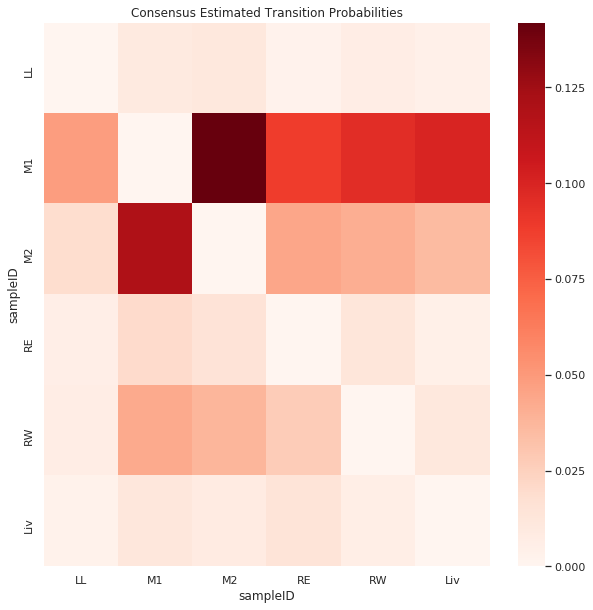

In [5]:
lg1 = lg_to_tree[1].get_network()
count_arr = ctp.compute_transitions(lg1, lg_meta['sampleID'])

count_arr /= np.sum(count_arr.values)

cmap = matplotlib.cm.RdBu
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(count_arr.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]], mask = np.fill_diagonal(np.zeros(count_arr.shape), 1), cmap="Reds")
plt.ylabel("sampleID")
plt.xlabel("sampleID")
plt.title("Consensus Estimated Transition Probabilities")

# lg1 = ctp.assign_labels(lg1,lg_meta['sampleID'])
# possible_labels = lg_meta['sampleID'].unique()

# C = sankoff_parsimony.sankoff(lg1, possible_labels=possible_labels)
# # print(C)
# pars = np.amin(C[0,:])
# print(pars)

# root = [n for n in lg1 if lg1.in_degree(n) == 0][0]
    
# bfs_postorder = [root]
# for e0, e1 in nx.bfs_edges(lg1, root):
#     bfs_postorder.append(e1)

# node_to_i = dict(zip(bfs_postorder, range(len(lg1.nodes))))
# label_to_j = dict(zip(possible_labels, range(len(possible_labels))))

# num_sol, t_mat = count_opt_solutions(lg1, C, root, node_to_i, label_to_j, t_mat = np.zeros((C.shape[1], C.shape[1])))
# print(t_mat / (pars * num_sol))

In [74]:
# t_mat /= (pars * num_sol)

t_mat = pd.DataFrame(t_mat)
t_mat

,0,1,2,3,4,5
0,0.0,2014.0,3162.0,3150.0,1262.0,1403.0
1,2275.0,0.0,3218.0,3169.0,1518.0,1743.0
2,3585.0,4060.0,0.0,4496.0,2533.0,1403.0
3,6131.0,7745.0,8577.0,0.0,5023.0,2992.0
4,1196.0,1645.0,2074.0,1868.0,0.0,841.0
5,730.0,1099.0,1061.0,726.0,635.0,0.0


## Form transition matrices

In [16]:
consensus_mat = ctp.build_consensus_transition_mat([tree.get_network() for tree in lg_to_tree.values()], lg_meta, 'sampleID', iterations=200)

100%|██████████| 99/99 [1:20:07<00:00, 48.56s/it]


In [17]:
consensus_mat.to_csv("consensus_transition_matrix.UNNORMALIZED.txt", sep='\t')
# consensus_mat = pd.read_csv("consensus_transition_matrix.UNNORMALIZED.txt", sep='\t', index_col = 0)

In [18]:
bg_dir = '/home/mattjones/projects/metastasis/JQ19/5k/transition_backgrounds/'
weights = {}

lgs = lg_to_tree.values()
total_size = np.sum([len(lg.network.nodes()) for lg in lgs])
num_lgs = len(lgs)
num_meta = len(lg_meta['sampleID'].unique())

for n in lg_to_tree.keys():
    weights[n] = len(lg_to_tree[n].network.nodes()) / total_size
    
bg_consensus = np.zeros((num_meta, num_meta))

for bgfp in os.listdir(bg_dir):
    
    bg = pd.read_csv(bg_dir + bgfp, sep='\t', index_col = 0)
    lg = bgfp.split("_")[0][2:]
    
    bg_consensus += bg * (weights[int(lg)] / num_lgs)

    labels = bg_consensus.columns
    bg_consensus = bg_consensus.values
    np.fill_diagonal(bg_consensus, np.nan)

    bg_consensus = pd.DataFrame(bg_consensus, index=labels, columns=labels)


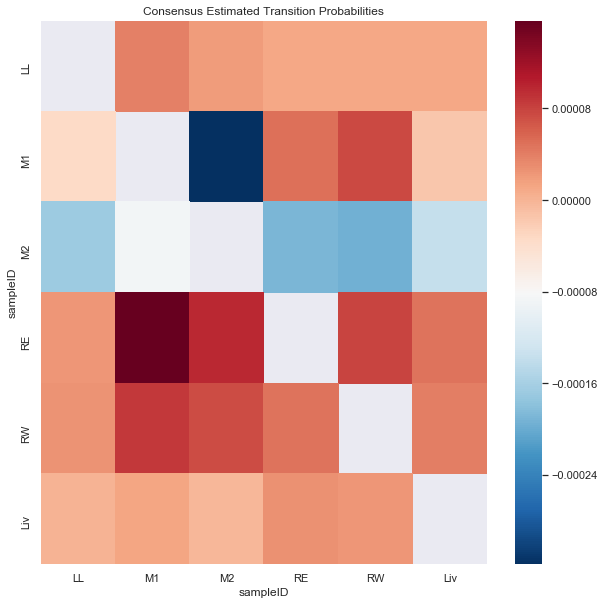

In [21]:
res = consensus_mat.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]] - bg_consensus.loc[['LL', "M1", "M2", "RE", 'RW', "Liv"], ['LL', "M1", "M2", "RE", 'RW', "Liv"]]

cmap = matplotlib.cm.RdBu
cmap.set_bad("white", 1.)
h = plt.figure(figsize=(10, 10))
sns.heatmap(res, mask = np.fill_diagonal(np.zeros(res.shape), 1), cmap="RdBu_r")
plt.ylabel("sampleID")
plt.xlabel("sampleID")
plt.title("Consensus Estimated Transition Probabilities")

plt.savefig('consensus_transition_matrix.NORMALIZED.pdf')